# Data 512: Course Project (Part 2 - An Extension Plan)

The recent increase in wildfire incidents has raised significant concerns regarding the health and economic impacts on communities, particularly in urban areas like Vancouver, WA. 

In the final part of the project, we aim to understand how smoke from wildfires affects respiratory health outcomes, hospitalization rates, and the economic stability of local industries. By focusing on this issue, we seek to provide valuable insights that can facilitate community preparedness, enhance public health responses, and inform city officials about necessary interventions. The goal is to learn about the relationship between increased smoke exposure and its potential consequences on community health and economic activity.

This is the second step of Part 3/4. In this notebook, 
- We will compare each of these features: `Respiratory Disease Mortality`, `Unemployment Rate`, `Premature Deaths`, and `Poverty Rate` with the estimated smoke impact. 
- For the features identified as having a relationship with smoke impact, we will perform a time series prediction to forecast their trends over the next 25 years. This will help us understand how they also vary with varying spoke impact prediction.

## 1. Import required libraries

In [1]:
# for data manipulation
import pandas as pd
import numpy as np

# for data visualization
import matplotlib.pyplot as plt

# for comparing Smoke estimate with AQI values
from scipy.stats import spearmanr

# for time series modeling
from statsmodels.tsa.arima.model import ARIMA

# to supress warnings
import warnings
warnings.filterwarnings("ignore")

Now before diving into modeling and analyzing each feature individually, we will first load all the data into DataFrames.

## 2. Load Data

In [2]:
# dataset which has the smoke impact
smoke_df = pd.read_csv('../data/input_data/wildfire-smoke-estimate_data/wildfire_dataset_with_distance_and_smoke_estimate_by_year.csv')
smoke_df.drop(columns=['Unnamed: 0', 'Mean_GIS_SqMiles', 'Mean_average_distance'], inplace=True)

print(smoke_df.shape)
smoke_df.head()

(60, 2)


,year,smoke_estimate_scaled
0,1961,5.704264
1,1962,2.064932
2,1963,7.274286
3,1964,5.476086
4,1965,2.190371


In [3]:
# data which has the AQI values
aqi_df = pd.read_csv('../data/input_data/AQI_data/filtered_fire_season_aqi_data_grouped_by_year.csv')
aqi_df.drop(columns=['Unnamed: 0'], inplace=True)

print(aqi_df.shape)
aqi_df.head()

(35, 2)


,year,AQI
0,1990,64.661290
1,1991,53.218750
2,1992,56.166667
3,1993,48.209677
4,1994,43.193548


In [31]:
# IHME Respiratory Mortality Rate
mortality = pd.read_csv("../data/input_data/healthcare_data/IHME_Respiratory_Disease_Mortality_Washington.CSV")

# get the details of Clark County
mortality_clark_all = mortality[mortality["location_name"] == "Clark County"]

# I am interested in the mortality rate for all the diseases / genders to visualize, so I will have that data
mortality_clark_all.drop(columns=['measure_id', 'measure_name', 'location_id', 'location_name', 
                              'FIPS', 'age_id', 'age_name', 'metric', 'cause_id','sex_id'], inplace=True)

mortality_clark_all.head()

,cause_name,sex,year_id,mx,lower,upper
630,Chronic respiratory diseases,Male,1980,74.559587,69.693866,79.623905
631,Chronic respiratory diseases,Male,1981,74.855265,70.095372,79.838698
632,Chronic respiratory diseases,Male,1982,74.373864,69.668210,79.110574
633,Chronic respiratory diseases,Male,1983,73.004129,68.661227,77.685383
634,Chronic respiratory diseases,Male,1984,75.848903,71.451555,80.311738


In [33]:
# But, I am interested in the mortality rate for all the diseases ("Chronic respiratory diseases") for both the sexes for a few of my analysis, so I will have that in a separate dataframe as well
mortality_clark = mortality_clark_all[(mortality_clark_all["cause_name"] == "Chronic respiratory diseases") &
                                    (mortality_clark_all["sex"] == "Both")]

# drop the columns which are not required
# We only have age_id = 27. So, we can drop this column as it doesn't provide any additional information
mortality_clark.drop(columns=['cause_name', 'sex'], inplace=True)

# rename the columns
mortality_clark.rename(columns={'year_id': 'year', 'mx': 'mortality_rate', 
                                'lower':'CI_lower', 'upper':'CI_upper'}, inplace=True)

print(mortality_clark.shape)
mortality_clark.head()

(35, 4)


,year,mortality_rate,CI_lower,CI_upper
700,1980,48.135061,45.820663,50.663420
701,1981,48.441273,45.946684,50.810790
702,1982,48.036330,45.627315,50.393823
703,1983,48.167729,45.964246,50.340094
704,1984,49.972637,47.759680,52.051930


In [5]:
# FRED Unemployment Rate
unemployment = pd.read_csv("../data/input_data/socioeconomic_data/FRED_Unemployment_rate_Clark_County.csv")

# rename columns for better readability
unemployment.rename(columns={"WACLAR1URN": "unemployment_rate"}, inplace=True)

# get year from date
unemployment["DATE"] = pd.to_datetime(unemployment["DATE"])
unemployment["year"] = unemployment["DATE"].dt.year
unemployment.drop("DATE", axis=1, inplace=True)

# group by and get the mean unemployment rate for each year
grouped_unemployment = unemployment.groupby("year")["unemployment_rate"].mean().reset_index()
print(grouped_unemployment.shape)
grouped_unemployment.head()


(35, 2)


,year,unemployment_rate
0,1990,4.683333
1,1991,6.158333
2,1992,7.033333
3,1993,5.866667
4,1994,4.591667


In [6]:
# FRED Poverty Rate
poverty = pd.read_csv("../data/input_data/socioeconomic_data/FRED_Poverty_Clark_County.csv")

# rename columns for better readability
poverty.rename(columns={"PPU18WA53011A156NCEN": "poverty_rate"}, inplace=True)

# handle missing values
poverty["poverty_rate"] = poverty["poverty_rate"].replace('.', np.nan)
poverty = poverty.dropna()
poverty["poverty_rate"] = pd.to_numeric(poverty["poverty_rate"], errors='coerce')

# get year from date
poverty["DATE"] = pd.to_datetime(poverty["DATE"])
poverty["year"] = poverty["DATE"].dt.year
poverty.drop("DATE", axis=1, inplace=True)

# group the rate by year
grouped_poverty = poverty.groupby("year")["poverty_rate"].mean().reset_index()
print(grouped_poverty.shape)
grouped_poverty.head()

(29, 2)


,year,poverty_rate
0,1989,15.5
1,1993,15.4
2,1995,13.0
3,1997,13.5
4,1998,12.2


In [7]:
# FRED Premature Deaths
premature_deaths = pd.read_csv("../data/input_data/socioeconomic_data/FRED_Premature_Deaths_Clark_County.csv")

# rename columns for better readability
premature_deaths.rename(columns={"CDC20N2U053011": "death_rate_per_100k"}, inplace=True)

# get year from date
premature_deaths["DATE"] = pd.to_datetime(premature_deaths["DATE"])
premature_deaths["year"] = premature_deaths["DATE"].dt.year
premature_deaths.drop("DATE", axis=1, inplace=True)

# group the rate by year
grouped_premature_deaths = premature_deaths.groupby("year")["death_rate_per_100k"].mean().reset_index()

print(grouped_premature_deaths.shape)
grouped_premature_deaths.head()


(22, 2)


,year,death_rate_per_100k
0,1999,300.5
1,2000,314.4
2,2001,299.1
3,2002,311.1
4,2003,298.1


Now, I thought it would be easier to join all these datasets by year into a single DataFrame. So let us do that!

In [8]:
compare_df = smoke_df.merge(aqi_df, on='year', how='outer') \
                    .merge(mortality_clark, on='year', how='outer') \
                    .merge(grouped_unemployment, on='year', how='outer') \
                    .merge(grouped_poverty, on='year', how='outer') \
                    .merge(grouped_premature_deaths, on='year', how='outer')

# rename columns for better readability
compare_df.rename(columns={'smoke_estimate_scaled': 'smoke_estimate', 'CI_lower':'mortality_CI_lower', 
                           'CI_upper':'mortality_CI_upper'}, inplace=True)

print(compare_df.shape)
compare_df.head()


(64, 9)


,year,smoke_estimate,AQI,mortality_rate,mortality_CI_lower,mortality_CI_upper,unemployment_rate,poverty_rate,death_rate_per_100k
0,1961,5.704264,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1962,2.064932,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1963,7.274286,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1964,5.476086,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1965,2.190371,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now, let us see how each of these features varies with changes in smoke impact.

## 3. Analyze feature variation with smoke impact

First let us analyze the estimated smoke impact with the Respiratory Mortality Rate

### 3.1 Smoke Estimate - Respiratory Mortality Rate

For each year, we have data on multiple respiratory diseases. The data includes annual mortality rates for males, females, and the combined population, covering various respiratory diseases.

I frst want to understand how the mortality rate is distributed across various diseases.

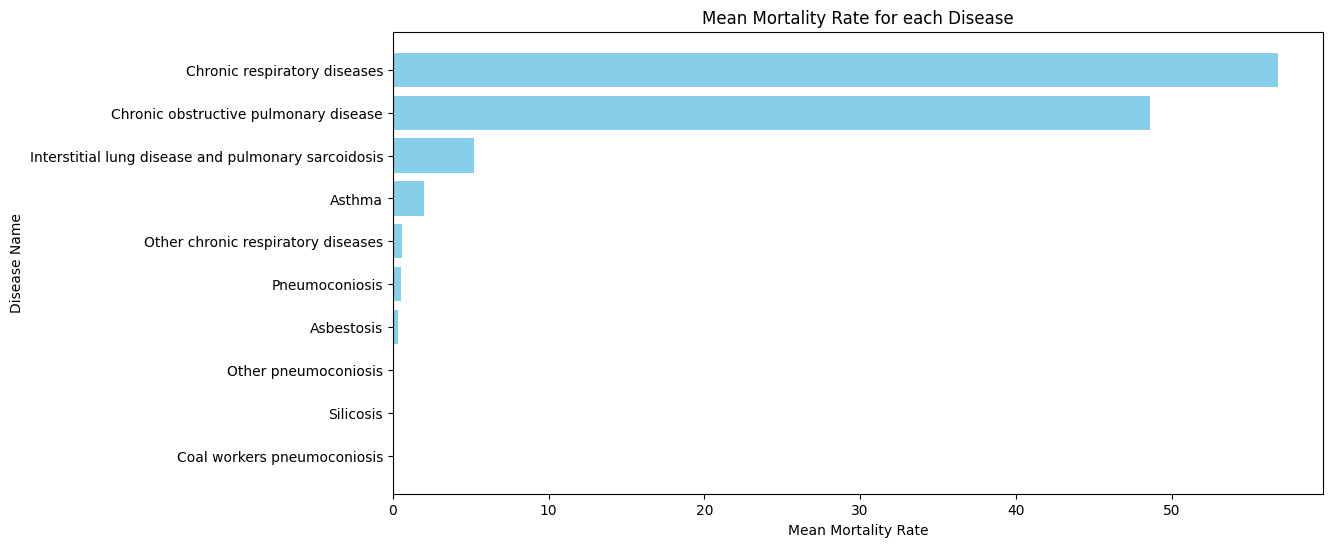

In [37]:
# So, I will first group the data by cause_name and get the mean mortality rate for each cause_name
mean_mx_per_cause = mortality_clark_all.groupby('cause_name')['mx'].mean().reset_index()
mean_mx_per_cause.rename(columns={'mx': 'mean_mx'}, inplace=True)
mean_mx_per_cause.sort_values(by='mean_mx', ascending=False, inplace=True)

# Plot
plt.figure(figsize=(12, 6))
plt.barh(mean_mx_per_cause['cause_name'], mean_mx_per_cause['mean_mx'], color='skyblue')
plt.xlabel('Mean Mortality Rate')
plt.ylabel('Disease Name')
plt.title('Mean Mortality Rate for each Disease')
plt.gca().invert_yaxis()
plt.show()

Looks like Chronic Respiratory diseases and Chronic Obstructive Pulmonary diseases on an average have 48.6% and 56.8% mortality rate. 

Chronic Respiratory Diseases (CRDs), including Chronic Obstructive Pulmonary Disease (COPD), are closely linked to wildfire smoke due to its harmful pollutants like fine particulate matter (PM2.5), carbon monoxide, and volatile organic compounds. These substances exacerbate symptoms of CRDs by triggering airway inflammation, reducing lung function, and causing acute respiratory distress. Prolonged exposure to wildfire smoke accelerates disease progression, increases hospitalizations, and raises mortality risk in individuals with CRDs. There are several studies showing significant spikes in emergency visits and respiratory-related deaths during wildfire events, highlighting the need for public health measures to protect vulnerable populations.

Now, I am interested to see how the diseases are distributed accross sexes.

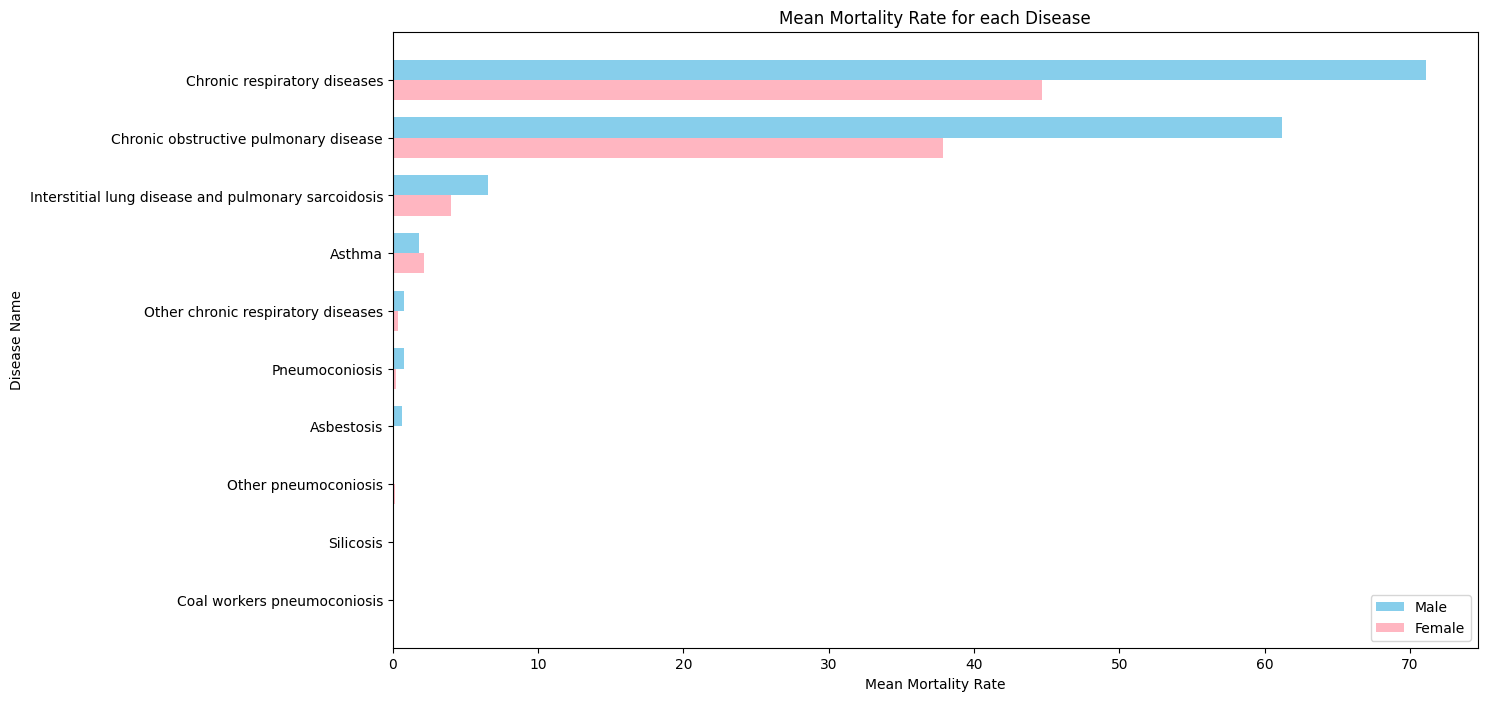

In [43]:
mean_mx_per_cause_sex = mortality_clark_all.groupby(['cause_name', 'sex'])['mx'].mean().reset_index()

pivot_data = mean_mx_per_cause_sex.pivot(index='cause_name', columns='sex', values='mx').reset_index() # Pivot the data for easier plotting
pivot_data['Total'] = pivot_data['Male'] + pivot_data['Female']
pivot_data.sort_values(by='Total', ascending=False, inplace=True)

# Plotting the data
plt.figure(figsize=(14, 8))
x = np.arange(len(pivot_data['cause_name']))
bar_width = 0.35
plt.barh(x - bar_width / 2, pivot_data['Male'], bar_width, label='Male', color='skyblue')
plt.barh(x + bar_width / 2, pivot_data['Female'], bar_width, label='Female', color='lightpink')
plt.xlabel('Mean Mortality Rate')
plt.ylabel('Disease Name')
plt.title('Mean Mortality Rate for each Disease')
plt.yticks(x, pivot_data['cause_name'])
plt.gca().invert_yaxis()
plt.legend(loc='lower right')
plt.show()

It looks like Males are mostly affected (except in case it is Asthma).

Because Chronic Respiratory Diseases are closely link to wildfire smokes, I will be filtering the dataset for this cause. I am also filtering to include both the sexes in the analysis. Now, let us see the relationship between Smoke estimate impact and Mortality Rate, are they correlated? Do they have an upward trend?

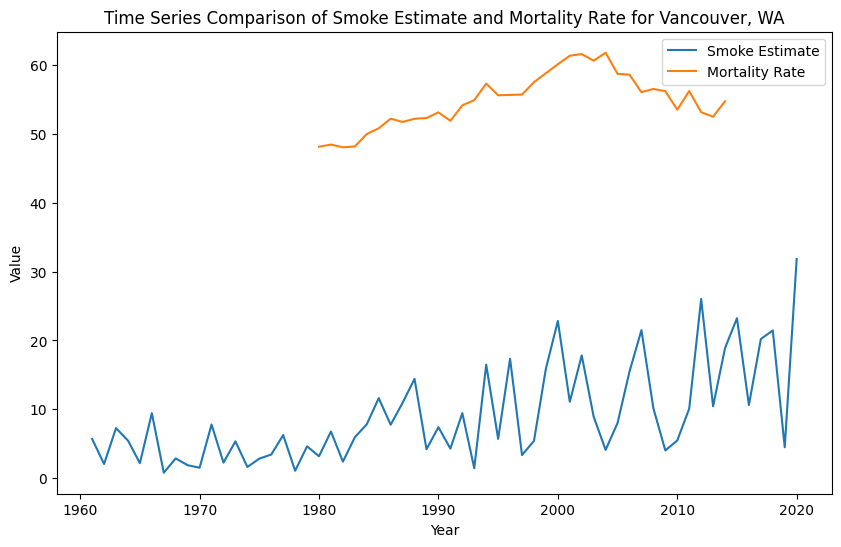

In [9]:
plot_smoke_mortality = compare_df.copy()
plot_smoke_mortality = plot_smoke_mortality[['year', 'smoke_estimate', 'mortality_rate']]

plt.figure(figsize=(10, 6))
plt.plot(plot_smoke_mortality['year'], plot_smoke_mortality['smoke_estimate'], label='Smoke Estimate')
plt.plot(plot_smoke_mortality['year'], plot_smoke_mortality['mortality_rate'], label='Mortality Rate')
plt.xlabel('Year')
plt.ylabel('Value')
plt.title(f'Time Series Comparison of Smoke Estimate and Mortality Rate for Vancouver, WA')
plt.legend()
plt.show()

Both the smoke estimate and mortality rate seem to exhibit increasing trends over the years. This suggests a potential link between increased air pollution and worsening respiratory health. The mortality rate exhibits more fluctuations compared to the smoke estimate - I do see the mortality rate rising in early 2000s and gradually decreasing after mid 2000s. 

Increased exposure to particulate matter and other pollutants in smoke can directly irritate the respiratory system, leading to chronic respiratory diseases like asthma, chronic obstructive pulmonary disease (COPD), and lung cancer. Smoke can also exacerbate existing respiratory conditions, leading to increased hospitalizations and mortality.
 
To strengthen the causal link between smoke exposure and chronic respiratory disease mortality, further research is needed, let's statistically compute the spearman correlation and see if there is actually a link between both the factors.

In [10]:
# Remove rows with missing values
plot_smoke_mortality = plot_smoke_mortality.dropna(subset=['smoke_estimate', 'mortality_rate'])

# Calculate Spearman correlation
spearman_corr, p_value = spearmanr(plot_smoke_mortality['smoke_estimate'], plot_smoke_mortality['mortality_rate'])
print("Spearman Correlation between Smoke Estimate and Respiratory Mortality Rate: ", spearman_corr)
print("P-value: ", p_value)

Spearman Correlation between Smoke Estimate and Respiratory Mortality Rate:  0.3179271708683474
P-value:  0.06271694401816089


The Spearman correlation coefficient of 0.318 between the Smoke Estimate and the Respiratory Mortality Rate suggests a weak to moderate positive monotonic relationship. This means that as smoke estimates increase, there is a tendency for respiratory mortality rates to increase as well, but the relationship is not very strong.

The p-value of 0.063 is slightly above the typical significance threshold of 0.05, indicating that this correlation is not statistically significant at the 5% level. However, it is close enough to suggest a potential trend, and with more data, the relationship might reach statistical significance.

To better understand its potential long-term impact, we will utilize a time series modeling approach to project the trajectory of smoke estimates and their influence on respiratory mortality over the next 25 years in the next step. This analysis will help quantify the risks and inform authorities about the potential health consequences, enabling them to take proactive measures to mitigate smoke-related impacts on public health.

### 3.2 Smoke Estimate - Unemployment Rate

Now let us see if unemployment rate varies with changing smoke estimate.

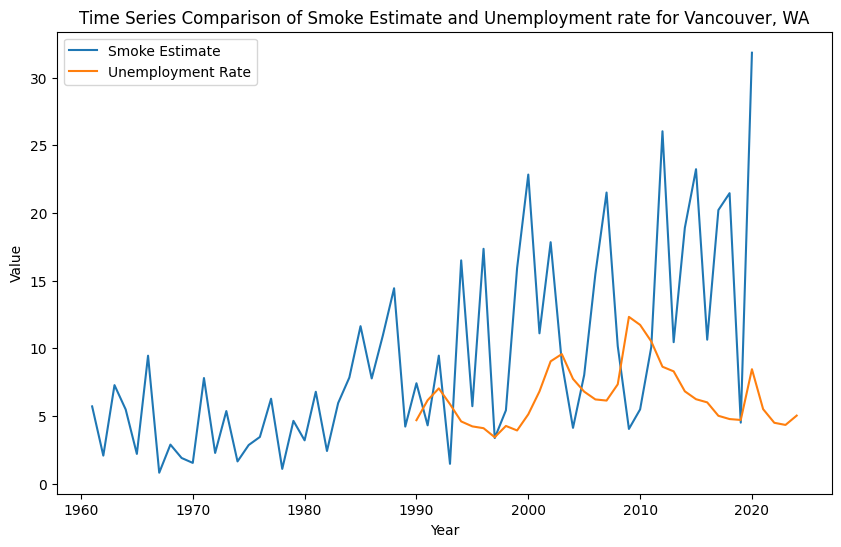

In [11]:
plot_smoke_unemployment = compare_df.copy()
plot_smoke_unemployment = plot_smoke_unemployment[['year', 'smoke_estimate', 'unemployment_rate']]

plt.figure(figsize=(10, 6))
plt.plot(plot_smoke_unemployment['year'], plot_smoke_unemployment['smoke_estimate'], label='Smoke Estimate')
plt.plot(plot_smoke_unemployment['year'], plot_smoke_unemployment['unemployment_rate'], label='Unemployment Rate')
plt.xlabel('Year')
plt.ylabel('Value')
plt.title(f'Time Series Comparison of Smoke Estimate and Unemployment rate for Vancouver, WA')
plt.legend()
plt.show()

Both variables (smoke estiomate and unemployment) exhibit significant fluctuations over time, reflecting dynamic changes in environmental and economic conditions. 
- There are periods where increases or decreases in smoke estimates appear to align with similar trends in the unemployment rate, suggesting a potential correlation. 
- However, in some instances, higher smoke estimates seem to precede increases in unemployment, hinting at a possible delayed impact. 

We need to do further investigation to understand the relationship here.

In [12]:
# Remove rows with missing values
plot_smoke_unemployment = plot_smoke_unemployment.dropna(subset=['smoke_estimate', 'unemployment_rate'])

# Calculate Spearman correlation
spearman_corr, p_value = spearmanr(plot_smoke_unemployment['smoke_estimate'], plot_smoke_unemployment['unemployment_rate'])
print("Spearman Correlation between Smoke Estimate and Unemployment rate: ", spearman_corr)
print("P-value: ", p_value)

Spearman Correlation between Smoke Estimate and Unemployment rate:  0.04516129032258065
P-value:  0.8093712112440687


The Spearman correlation coefficient of 0.045 and the p-value of 0.809 suggest that there is a very weak positive relationship between the Smoke Estimate and the Unemployment Rate in Vancouver, WA, but this relationship is not statistically significant. The high p-value indicates that any observed correlation is likely due to random chance rather than a meaningful connection. This finding suggests that fluctuations in smoke estimates and unemployment rates may not be directly related. 

Further analysis could explore whether external factors, such as economic policies or health-related disruptions, might influence both variables indirectly.

In this case, we will not proceed with a time series modeling approach to project the trajectory of smoke estimates and their influence on unemployment over the next 25 years. 

### 3.3 Smoke Estimate - Poverty Rate

Now let us see if poverty rate varies with changing smoke estimate.

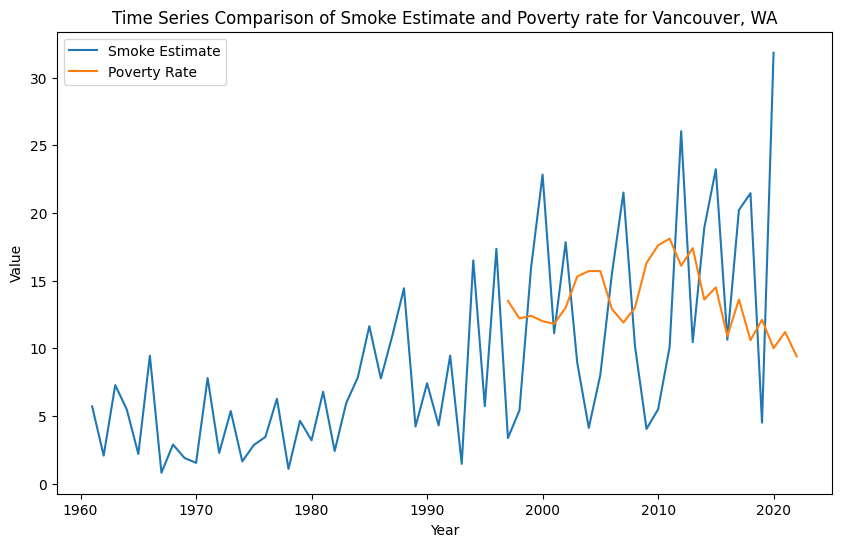

In [13]:
plot_smoke_poverty = compare_df.copy()
plot_smoke_poverty = plot_smoke_poverty[['year', 'smoke_estimate', 'poverty_rate']]

plt.figure(figsize=(10, 6))
plt.plot(plot_smoke_poverty['year'], plot_smoke_poverty['smoke_estimate'], label='Smoke Estimate')
plt.plot(plot_smoke_poverty['year'], plot_smoke_poverty['poverty_rate'], label='Poverty Rate')
plt.xlabel('Year')
plt.ylabel('Value')
plt.title(f'Time Series Comparison of Smoke Estimate and Poverty rate for Vancouver, WA')
plt.legend()
plt.show()

The plot shows a complex relationship between smoke estimates and poverty rates in Vancouver, WA. While there isn't a clear, consistent correlation, we can observe some interesting patterns:
- Both smoke estimates and poverty rates exhibit significant fluctuations over time. 
- In some periods, we see a positive correlation, where both smoke estimates and poverty rates increase or decrease together. This could be due to factors like economic downturns or severe wildfire seasons that impact both economic conditions and smoke impact.
- However, in all other instances, increases in poverty rates seem to follow periods of high smoke estimates. This might suggest that the economic and health impacts of wildfires and air pollution can have delayed effects on poverty levels.

To gain a deeper understanding of the relationship between smoke and poverty, further analysis is needed.

In [14]:
# Remove rows with missing values
plot_smoke_poverty = plot_smoke_poverty.dropna(subset=['smoke_estimate', 'poverty_rate'])

# Calculate Spearman correlation
spearman_corr, p_value = spearmanr(plot_smoke_poverty['smoke_estimate'], plot_smoke_poverty['poverty_rate'])
print("Spearman Correlation between Smoke Estimate and Poverty rate: ", spearman_corr)
print("P-value: ", p_value)

Spearman Correlation between Smoke Estimate and Poverty rate:  -0.41093815001313544
P-value:  0.03322566997405962


The Spearman correlation of -0.411 and the p-value of 0.033 suggest a moderate negative relationship between the Smoke Estimate and Poverty Rate, which means that, areas with higher poverty rates tend to have lower smoke estimates. This finding might seem counterintuitive at first, however, it can be observed that increases in poverty rates seem to follow periods of high smoke estimates.

The delay in the observed increase in poverty after high smoke estimates could be due to a lag in both physical and economic recovery. The immediate health impacts might not show up right away, and the economic disruptions caused by wildfires (such as job losses and business closures) may take some time to manifest fully. Once these effects accumulate, they can lead to long-term increases in poverty, especially for communities already vulnerable due to their low-income status.

To better understand its potential long-term impact, we will utilize a time series modeling approach to project the trajectory of smoke estimates and their influence on poverty over the next 25 years in the next step. This analysis will help quantify the risks and inform authorities about the potential financial consequences, enabling them to take proactive measures to mitigate smoke-related impacts on the society.

### 3.3 Smoke Estimate - Premature Deaths

Now let us see if premature deaths varies with changing smoke estimate.

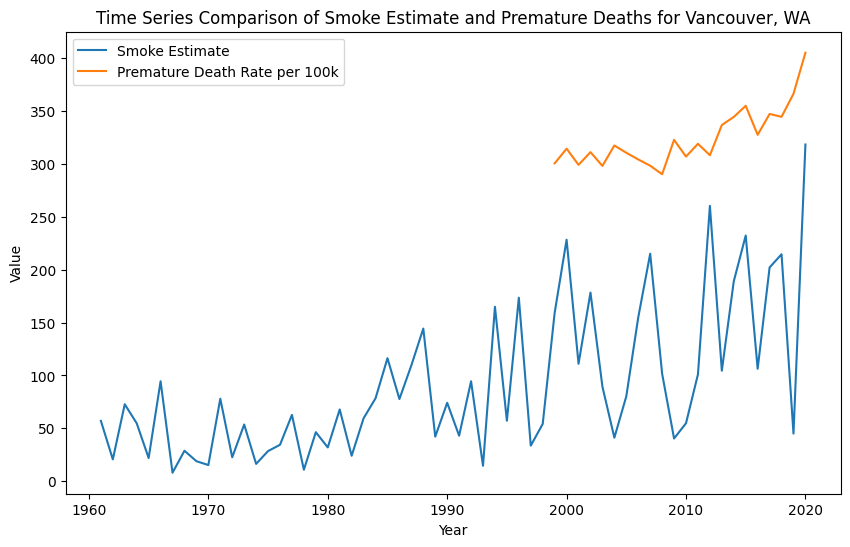

In [15]:
plot_smoke_premature_deaths = compare_df.copy()
plot_smoke_premature_deaths = plot_smoke_premature_deaths[['year', 'smoke_estimate', 'death_rate_per_100k']]

plot_smoke_premature_deaths['smoke_estimate'] = plot_smoke_premature_deaths['smoke_estimate'] * 10

plt.figure(figsize=(10, 6))
plt.plot(plot_smoke_premature_deaths['year'], plot_smoke_premature_deaths['smoke_estimate'], label='Smoke Estimate')
plt.plot(plot_smoke_premature_deaths['year'], plot_smoke_premature_deaths['death_rate_per_100k'], label='Premature Death Rate per 100k')
plt.xlabel('Year')
plt.ylabel('Value')
plt.title(f'Time Series Comparison of Smoke Estimate and Premature Deaths for Vancouver, WA')
plt.legend()
plt.show()

Over the years, there is an overall increasing trend in smoke estimates, which could be linked to factors such as heightened wildfire activity, evolving air quality monitoring techniques, or population growth. 

In contrast, the premature death rate per 100,000 people fluctuates, influenced by a variety of factors including demographic shifts, advancements in healthcare, and socioeconomic conditions. While there may not be a strong, direct correlation between the two time series, it is plausible that periods of higher smoke estimates could align with increases in premature death rates, especially for vulnerable populations. 

Let us observe this statistically. 

In [16]:
# Remove rows with missing values
plot_smoke_premature_deaths = plot_smoke_premature_deaths.dropna(subset=['smoke_estimate', 'death_rate_per_100k'])

# Calculate Spearman correlation
spearman_corr, p_value = spearmanr(plot_smoke_premature_deaths['smoke_estimate'], plot_smoke_premature_deaths['death_rate_per_100k'])
print("Spearman Correlation between Smoke Estimate and Premature Deaths per 100k: ", spearman_corr)
print("P-value: ", p_value)

Spearman Correlation between Smoke Estimate and Premature Deaths per 100k:  0.1925465838509317
P-value:  0.39062682819034467


The Spearman correlation of 0.193 between the smoke estimate and premature deaths per 100k suggests a weak positive relationship, meaning that as smoke estimates increase, there is a slight increase in premature deaths, but the relationship is not strong. The p-value of 0.391 is much higher than the typical significance threshold of 0.05, indicating that this correlation is not statistically significant. This suggests that while there may be some association between the two variables, it is likely due to chance, and there is no clear evidence to support a strong or meaningful link between higher smoke estimates and an increase in premature death rates in this case.

Further analysis, potentially with additional variables or more specific data, would be needed to draw definitive conclusions.

In this case, we will not proceed with a time series modeling approach to project the trajectory of smoke estimates and their influence on premature deaths over the next 25 years. 

## 4. Time series Modeling

Next, we'll use Time Series Modeling to better understand how smoke estimates could affect poverty rates and respiratory health over the next 25 years (i.e., 2025-2050). This will help us predict the future impact of smoke on society, including potential health problems and costs. With this information, authorities can take early action to reduce the negative effects of smoke on people’s well-being.

As we did for forcasting smoke impact, we will user ARIMA in this case as well. 

ARIMA (AutoRegressive Integrated Moving Average) is a robust model specifically designed for analyzing and forecasting time series data. It is capable of modeling trends (e.g., increasing smoke estimates over the years), particularly through its differencing parameter (d) which helps in achieving stationarity. They incorporate both autoregressive (past values) and moving average (past forecast errors) components, allowing it to capture complex relationships in the data that simpler models may overlook. In this project, I did not explore any other models in depth and will be using this for further analysis.

In [17]:
def arima_fit_and_predict(data, model_order, num_steps):
    
    arima_model = ARIMA(data, order=model_order)
    model_results = arima_model.fit()
    
    predictions = model_results.forecast(steps=num_steps) # predict future values
    residuals = model_results.resid
    standard_error = np.std(residuals) # compute the standard error using the residuals
    
    # calculate confidence intervals (95% confidence interval)
    lower_limits = predictions - 1.96 * standard_error
    upper_limits = predictions + 1.96 * standard_error
    
    return predictions, lower_limits, upper_limits

In the previous notebook, we identified the optimal ARIMA configuration to be (6, 1, 3):
- p = 6: Model includes six lagged observations of the dependent variable in predicting future values. The autoregressive component (AR) captures the relationship between the current observation and its previous four values, allowing the model to use more information from the recent past.
- d = 1: Model applies first differencing to the time series data to achieve stationarity. Differencing one times removes trends and seasonality from the data, effectively making the series stationary for better model performance.
- q = 3: Model incorporates three lagged forecast errors in its predictions. The moving average component (MA) helps to account for the influence of past error terms on the current observation.

Model is applying d=1 by itself. For simplicity, we will be reusing these terms in this forcasting as well.

Now let us fit the model for `Smoke Estimate`, `Respiratory Disease Mortality`, and `Poverty Rate` and forcast for next 25yrs.

### 4.1 Model Fitting and Forecasting

In [18]:
num_forecast_years = 25  # Number of years to forecast

best_order = (6,1,3) # best ARIMA configuaration

# fit the model - Smoke Estimate
predicted_smoke, smoke_lower_bound, smoke_upper_bound = arima_fit_and_predict(compare_df['smoke_estimate'], 
                                                                            best_order,
                                                                            num_forecast_years)
# fit the model - Resipratory Mortality Rate
predicted_mortality_rate, mortality_lower_bound, mortality_upper_bound = arima_fit_and_predict(compare_df['mortality_rate'], 
                                                                                            (5,0,5),
                                                                                            num_forecast_years)
# fit the model - Poverty Rate
predicted_poverty_rate, poverty_lower_bound, poverty_upper_bound = arima_fit_and_predict(compare_df['poverty_rate'], 
                                                                                        (7,0,0),
                                                                                        num_forecast_years)
# combine the results to a single df
forecast_df = pd.DataFrame({'year': range(2025, 2050),
                            'predicted_smoke': predicted_smoke,
                            'predicted_mortality_rate': predicted_mortality_rate,
                            'predicted_poverty_rate': predicted_poverty_rate,
                            'smoke_lower_limit': smoke_lower_bound,
                            'smoke_upper_limit': smoke_upper_bound,
                            'mortality_lower_limit': mortality_lower_bound,
                            'mortality_upper_limit': mortality_upper_bound,
                            'poverty_lower_limit': poverty_lower_bound,
                            'poverty_upper_limit': poverty_upper_bound})
forecast_df.reset_index(drop=True, inplace=True)
forecast_df.head()

,year,predicted_smoke,predicted_mortality_rate,predicted_poverty_rate,smoke_lower_limit,smoke_upper_limit,mortality_lower_limit,mortality_upper_limit,poverty_lower_limit,poverty_upper_limit
0,2025,16.835377,49.842962,14.293344,6.252237,27.418516,46.894564,52.791359,11.817961,16.768728
1,2026,23.764806,51.720652,13.579611,13.181667,34.347946,48.772254,54.669049,11.104227,16.054995
2,2027,13.487267,50.520774,15.313853,2.904127,24.070406,47.572376,53.469171,12.838469,17.789237
3,2028,21.544551,51.429766,14.150194,10.961412,32.127690,48.481369,54.378164,11.674810,16.625578
4,2029,17.919400,51.949055,15.549363,7.336261,28.502539,49.000657,54.897452,13.073979,18.024747


To visualize better, let us plot the forcasted results alongside the historical data.

### 4.2 Data Visualization
#### 4.2.1 Smoke Estimate

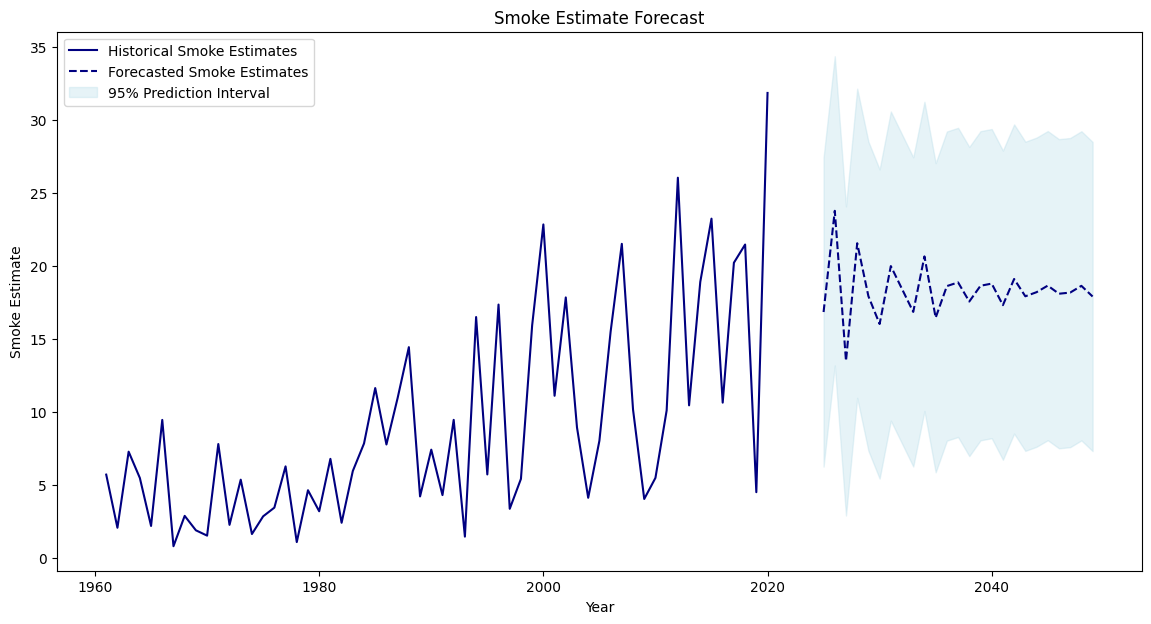

In [19]:
plt.figure(figsize=(14, 7))

# plot the historical data
plt.plot(compare_df['year'], 
         compare_df['smoke_estimate'], 
         label='Historical Smoke Estimates', 
         color='navy')
# plot the forcasted data
plt.plot(forecast_df['year'], 
         forecast_df['predicted_smoke'], 
         label='Forecasted Smoke Estimates', 
         color='navy', 
         linestyle='--')
# have the prediction intervals
plt.fill_between(forecast_df['year'], 
                 forecast_df['smoke_lower_limit'], 
                 forecast_df['smoke_upper_limit'], 
                 color='lightblue', 
                 alpha=0.3, 
                 label='95% Prediction Interval')

plt.title('Smoke Estimate Forecast')
plt.xlabel('Year')
plt.ylabel('Smoke Estimate')
plt.legend()
plt.show()

**Historical Data:**
- There's a clear upward trend in historical smoke estimates, suggesting a potential increase in wildfire activity or other factors contributing to smoke.
- The fluctuations in the historical data indicate variability in yearly smoke levels.

**Forecasted Smoke Estimates:**
- The forecasted smoke estimates show a continuation of the upward trend observed in the historical data.
- The dashed line represents the most likely future path of smoke estimates, while the shaded area (95% prediction interval) indicates the range of uncertainty. The wider the prediction interval, the greater the uncertainty in the forecast. The wider interval in this case could be because we do not have a lot of data to perform the forcast.

To improve the accuracy of the forecast, it's crucial to consider other factors influencing smoke estimate (other than what is considered in the formula) and incorporate more detailed data and advanced modeling techniques.

#### 4.2.2 Chronic Respiratory Illness - Mortality Rate

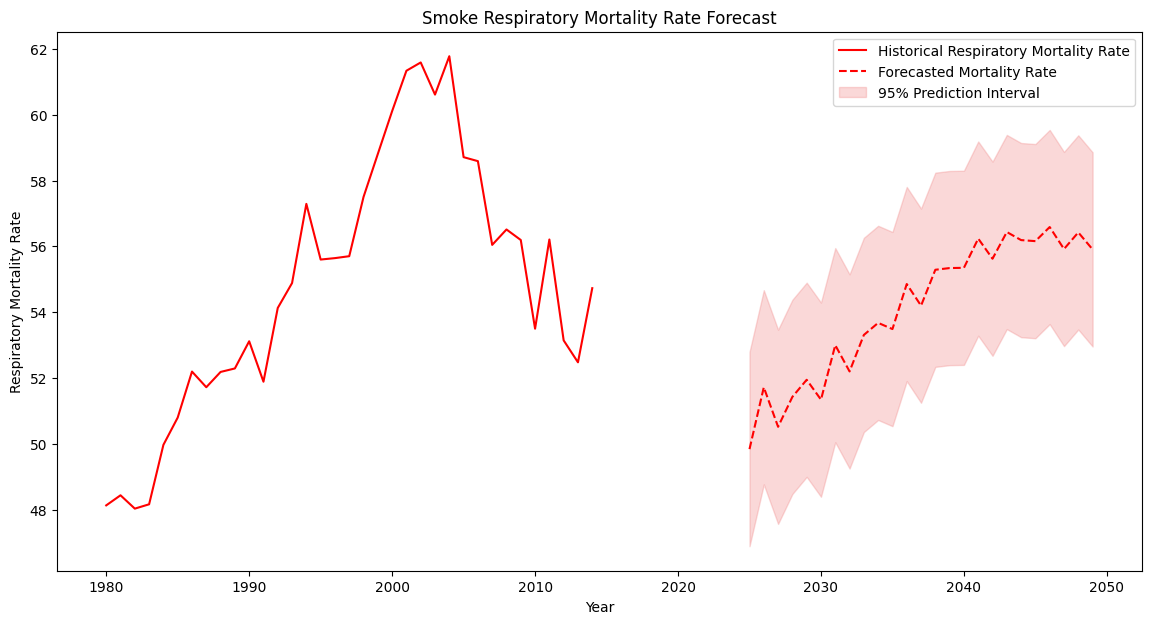

In [20]:
plt.figure(figsize=(14, 7))

# plot the historical mortality rate data
plt.plot(compare_df['year'], 
         compare_df['mortality_rate'], 
         label='Historical Respiratory Mortality Rate', 
         color='red')
# plot the forcasted mortality rate estimate data
plt.plot(forecast_df['year'], 
         forecast_df['predicted_mortality_rate'], 
         label='Forecasted Mortality Rate', 
         color='red', 
         linestyle='--')
# have the prediction intervals for mortality rate estimate
plt.fill_between(forecast_df['year'], 
                 forecast_df['mortality_lower_limit'], 
                 forecast_df['mortality_upper_limit'], 
                 color='lightcoral', 
                 alpha=0.3, 
                 label='95% Prediction Interval')

plt.title('Smoke Respiratory Mortality Rate Forecast')
plt.xlabel('Year')
plt.ylabel('Respiratory Mortality Rate')
plt.legend()
plt.show()

**Historical Data:**
- There's a general upward trend in respiratory mortality rates, suggesting a potential increase in respiratory health issues over time.
- The historical data also exhibits fluctuations, indicating variations in mortality rates from year to year, likely influenced by factors such as air quality, socioeconomic conditions, and healthcare access.

**Forecasted Estimates:**
- The forecast predicts a continued upward trend in respiratory mortality rates, with a widening prediction interval towards the end of the forecast period.
- The wider prediction interval indicates increased uncertainty in the future projections, suggesting that multiple factors could influence the actual trajectory of respiratory mortality rates.trend in respiratory mortality rates, with a widening prediction interval towards the end of the forecast period.

To improve the accuracy of the forecast, it's crucial to consider other factors and incorporate more detailed data and advanced modeling techniques. Additionally, ongoing monitoring and evaluation of public health interventions are essential to mitigate the impact of air pollution and other factors on respiratory health.

#### 4.2.3 Poverty Rate

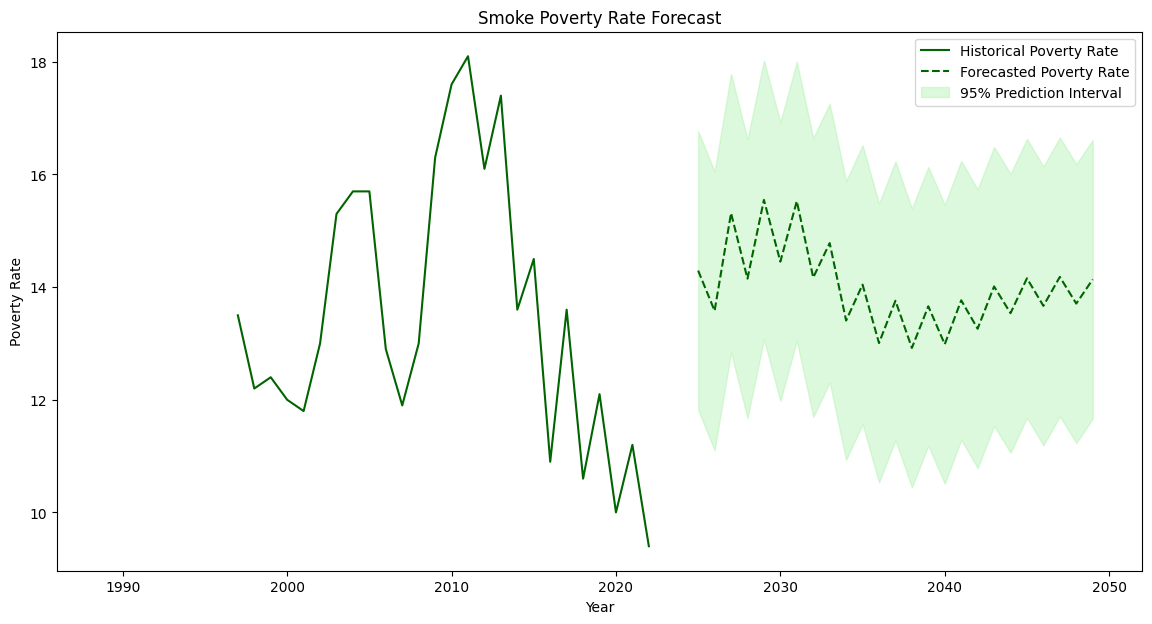

In [21]:
plt.figure(figsize=(14, 7))

# plot the historical poverty rate data
plt.plot(compare_df['year'], 
         compare_df['poverty_rate'], 
         label='Historical Poverty Rate', 
         color='darkgreen')
# plot the forcasted poverty rate estimate data
plt.plot(forecast_df['year'], 
         forecast_df['predicted_poverty_rate'], 
         label='Forecasted Poverty Rate', 
         color='darkgreen', 
         linestyle='--')
# have the prediction intervals for poverty rate estimate
plt.fill_between(forecast_df['year'], 
                 forecast_df['poverty_lower_limit'], 
                 forecast_df['poverty_upper_limit'], 
                 color='lightgreen', 
                 alpha=0.3, 
                 label='95% Prediction Interval')

plt.title('Smoke Poverty Rate Forecast')
plt.xlabel('Year')
plt.ylabel('Poverty Rate')
plt.legend()
plt.show()

**Historical Data:**
- The historical poverty rate exhibits significant fluctuations, suggesting that various factors influence poverty levels. These factors could include economic cycles, social policies, and demographic changes.

**Forecasted Estimates:**
- The forecast suggests a continued fluctuating trend in poverty rates, with periods of increase and decrease. This indicates that poverty is likely to remain a complex issue with no simple solution.
- The wide prediction interval highlights the uncertainty associated with future poverty rates. This uncertainty is likely due to the numerous factors that can influence poverty levels and the difficulty in accurately predicting future economic and social conditions.

While the forecast suggests that poverty will remain a persistent issue, it's important to note that effective policies and interventions can help mitigate its impact.

### 4.2.4 Combined Plot

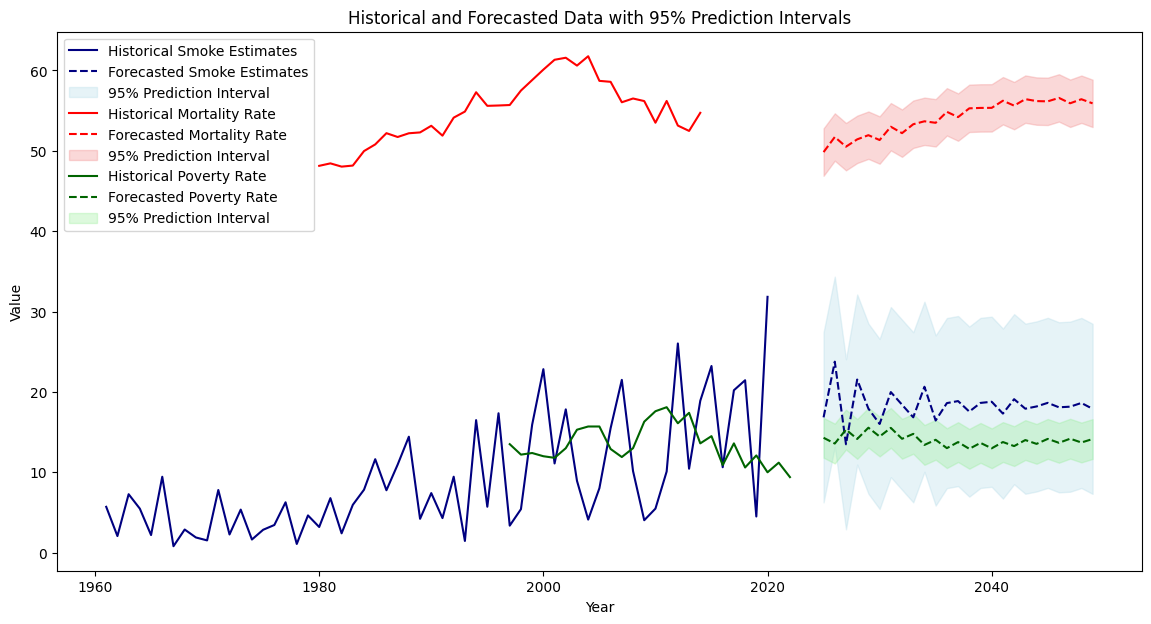

In [25]:
plt.figure(figsize=(14, 7))

# plot the historical data
plt.plot(compare_df['year'], 
         compare_df['smoke_estimate'], 
         label='Historical Smoke Estimates', 
         color='navy')
# plot the forcasted data
plt.plot(forecast_df['year'], 
         forecast_df['predicted_smoke'], 
         label='Forecasted Smoke Estimates', 
         color='navy', 
         linestyle='--')
# have the prediction intervals
plt.fill_between(forecast_df['year'], 
                 forecast_df['smoke_lower_limit'], 
                 forecast_df['smoke_upper_limit'], 
                 color='lightblue', 
                 alpha=0.3, 
                 label='95% Prediction Interval')

# plot the historical mortality rate data
plt.plot(compare_df['year'], 
         compare_df['mortality_rate'], 
         label='Historical Mortality Rate', 
         color='red')
# plot the forcasted mortality rate estimate data
plt.plot(forecast_df['year'], 
         forecast_df['predicted_mortality_rate'], 
         label='Forecasted Mortality Rate', 
         color='red', 
         linestyle='--')
# have the prediction intervals for mortality rate estimate
plt.fill_between(forecast_df['year'], 
                 forecast_df['mortality_lower_limit'], 
                 forecast_df['mortality_upper_limit'], 
                 color='lightcoral', 
                 alpha=0.3, 
                 label='95% Prediction Interval')

# plot the historical poverty rate data
plt.plot(compare_df['year'], 
         compare_df['poverty_rate'], 
         label='Historical Poverty Rate', 
         color='darkgreen')
# plot the forcasted poverty rate estimate data
plt.plot(forecast_df['year'], 
         forecast_df['predicted_poverty_rate'], 
         label='Forecasted Poverty Rate', 
         color='darkgreen', 
         linestyle='--')
# have the prediction intervals for poverty rate estimate
plt.fill_between(forecast_df['year'], 
                 forecast_df['poverty_lower_limit'], 
                 forecast_df['poverty_upper_limit'], 
                 color='lightgreen', 
                 alpha=0.3, 
                 label='95% Prediction Interval')

plt.title('Historical and Forecasted Data with 95% Prediction Intervals')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend(loc='upper left')
plt.show()

**Overall Trend:**

The combined plot illustrates a complex interplay between smoke estimates, mortality rates, and poverty rates over time. While there are fluctuations, a general upward trend is evident in all three variables, suggesting a potential link between increased smoke exposure and adverse health and socioeconomic outcomes.

**Key Observations:**
- **Increasing Smoke Estimates:** The historical smoke estimates show a clear upward trend, indicating a potential increase in wildfire activity or other factors contributing to air pollution.
- **Rising Mortality Rates:** The historical mortality rates also exhibit an upward trend, which could be partially attributed to the increasing exposure to air pollution.
- **Fluctuating Poverty Rates:** The poverty rate shows fluctuations over time, but there is a general upward trend, particularly in recent years.

**Potential Relationships:**
- **Smoke Impact and Mortality:** Increased exposure to air pollution, particularly from wildfires, can lead to respiratory problems, cardiovascular diseases, and other health issues, which can contribute to increased mortality rates.
- **Smoke Impact and Poverty:** Wildfires can have significant economic impacts, such as job losses, business closures, and increased healthcare costs. These economic disruptions can exacerbate poverty and inequality.

**Policy Implications:**
To mitigate the negative impacts of increased smoke, mortality, and poverty, policymakers should consider the following strategies:
- **Immediate Response and Public Health:**
    - **Real-time Air Quality Monitoring:** Invest in advanced air quality monitoring systems to provide real-time information to the public.
    - **Public Health Alerts:** Issue timely alerts and advisories to inform the public about air quality conditions and recommend protective measures.
    - **Clean Air Shelters:** Establish designated clean air shelters, particularly in vulnerable communities, to provide refuge during periods of poor air quality.
    - **Healthcare Resources:** Increase healthcare resources to address respiratory illnesses and other health problems associated with smoke exposure.
- **Long-Term Mitigation and Adaptation:**
    - **Forest Management:** Implement proactive forest management practices, such as controlled burns and thinning, to reduce the risk of large, intense wildfires.
    - **Climate Change Mitigation:** Support policies and initiatives to reduce greenhouse gas emissions and mitigate climate change, which can contribute to more frequent and severe wildfires.
    - **Community Planning and Resilience:** Develop community plans to identify vulnerable areas and implement strategies to reduce exposure to smoke, such as improving air filtration systems in homes and schools.
    - **Economic Recovery:** Provide economic support to communities affected by wildfires, including assistance with rebuilding infrastructure, job training, and small business development.
    - **Research and Innovation:** Invest in research to develop innovative technologies to reduce wildfire risk, improve air quality monitoring, and develop effective health interventions.

By implementing these policies, policymakers can help protect public health, reduce economic losses, and build more resilient communities in the face of increasing wildfire smoke.